In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from IPython.display import clear_output
clear_output()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup

import torch
import os
from tqdm import tqdm
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.optim import AdamW
from transformers import  get_cosine_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

import warnings
warnings.simplefilter("ignore", category=FutureWarning)
print('compelet')


2025-05-19 05:53:00.770483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747633980.963192      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747633981.014474      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


compelet


### ***数据探索***

In [5]:
# Load the dataset
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [8]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [9]:
df.duplicated().sum()

418

In [10]:
df.drop_duplicates(inplace=True)

***我们根据上面的分析***
 * 这个数据有50000条数据,其中25000条是积极的,25000条是消极的,数据均衡.
 * 本身没有空值
 * 有418条重复数据 
 

### ***数据处理***

####  ***文本清洗***
  * 根据上面分析的结果,我们删除数据中一些不利于情感分析的数据;
  * 为了避免大小写差异,造成模型误判,把文本统一为小写;
  * 移除URL,删除所有网址
  * 移除用户提及和话题标签
  * 移除标点符号

In [11]:

def preprocess_cleaning(text):
    # remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    text = text.lower()
    # remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # remove user mentions and hashtags
    text = re.sub(r'@\w+|\#', '', text)
    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

#### ***通用停用词处理***
  * 保留消极情感通用词和明确情感词

In [12]:
stop_words = set(stopwords.words('english'))
# 否定词（全部保留）
negatives = {
    "no", "not", "nor", "neither", "none", "never", "nobody", "nowhere", "nothing",
    "don't", "doesn't", "didn't", "won't", "wouldn't", "can't", "couldn't",
    "isn't", "aren't", "wasn't", "weren't", "haven't", "hasn't", "hadn't",
    "shouldn't", "mustn't", "mightn't", "needn't", 'don', 'won', 'aren', 'couldn',
    'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'mightn', 'mustn', 'needn', 
    'shan', 'shouldn', 'wasn', 'weren', 'wouldn'
}

# 绝对明确的情感词（保留）
# strong_sentiment_words = {
#     "best", "worst", "excellent", "terrible", "wonderful", 
#     "happy", "sad", "love", "hate", "disappoint", "proud",
#     "sorry","thanks", "thanx"
# }

# 自定义停用词 = 标准停用词 - (否定词 + 绝对明确情感词)
custom_stop_words = stop_words - negatives #- strong_sentiment_words

def preprocess_stopwords(text):
    """预处理文本，移除自定义停用词但保留否定词和明确情感词"""
    # Tokenize
    tokens = word_tokenize(text)
    # 移除自定义停用词（保留否定词和明确情感词）
    tokens = [word for word in tokens if word not in custom_stop_words]
    # 返回处理后的文本
    return ' '.join(tokens)

In [13]:

def preprocess_text(text):
    text = preprocess_cleaning(text)
    text = preprocess_stopwords(text)
    return text

# Apply preprocessing
df['processed_text'] = df['review'].apply(preprocess_text)

In [14]:
n = 1
print(f"data before preprocessing : {df['review']}")
print(f"data after preprocessing : {df['processed_text']}")


data before preprocessing : 0        One of the other reviewers has mentioned that ...
1        A wonderful little production. <br /><br />The...
2        I thought this was a wonderful way to spend ti...
3        Basically there's a family where a little boy ...
4        Petter Mattei's "Love in the Time of Money" is...
                               ...                        
49995    I thought this movie did a down right good job...
49996    Bad plot, bad dialogue, bad acting, idiotic di...
49997    I am a Catholic taught in parochial elementary...
49998    I'm going to have to disagree with the previou...
49999    No one expects the Star Trek movies to be high...
Name: review, Length: 49582, dtype: object
data after preprocessing : 0        one reviewers mentioned watching 1 oz episode ...
1        wonderful little production filming technique ...
2        thought wonderful way spend time hot summer we...
3        basically theres family little boy jake thinks...
4        petter m

#### ***长文本分离***
  * 在Transformer中有最大长度限制,超过限制会自动截断,所以把数据分成两个df去进行数据处理;
  * 长文本处理放在长文本位置,此后在考虑使用平均加权得分等方法去处理
  * 短文本处理是主要任务

In [15]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
max_length = 512

normal_texts = []
normal_labels = []
long_texts = []
long_labels = []

for text, label in zip(df['processed_text'], df['sentiment']):
    tokens = tokenizer.encode(text, add_special_tokens=True)
    if len(tokens) <= max_length:
        normal_texts.append(text)
        normal_labels.append(label)
    else:
        long_texts.append(text)
        long_labels.append(label)

df = pd.DataFrame({'processed_text': normal_texts, 'sentiment': normal_labels})

df_long = pd.DataFrame({'processed_text': long_texts, 'sentiment': long_labels})

df_long.to_csv("long_texts.csv", index=False)
df.to_csv("texts.csv",index=False)

print(f"标准长度评论（≤{max_length} tokens）数量: {len(df)}")
print(f"超长评论（>{max_length} tokens）数量: {len(df_long)}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (605 > 512). Running this sequence through the model will result in indexing errors


标准长度评论（≤512 tokens）数量: 48521
超长评论（>512 tokens）数量: 1061


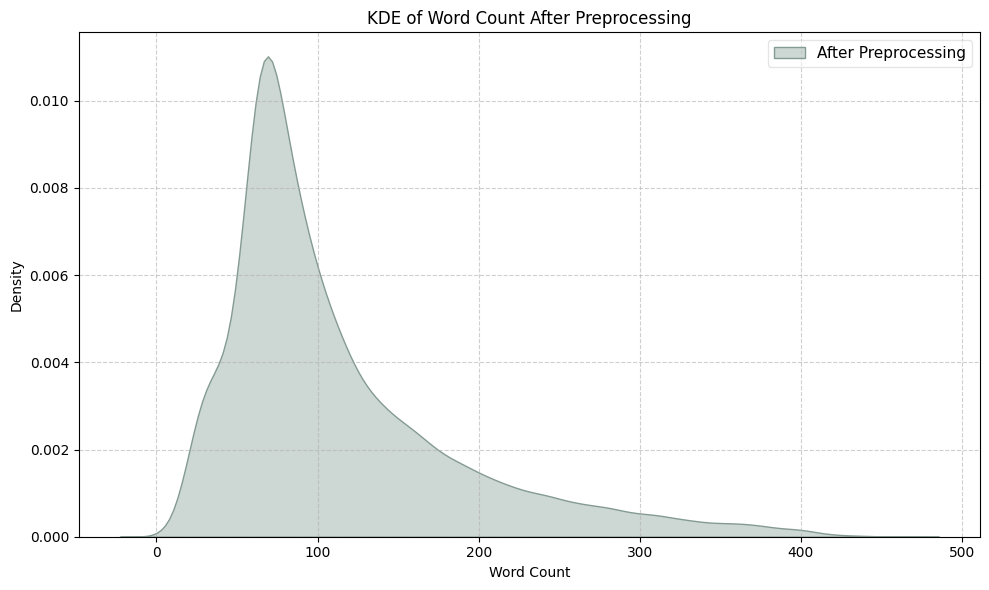

In [16]:
df['processed_length'] = df['processed_text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
sns.kdeplot(df['processed_length'], color='#849b91', label='After Preprocessing', fill=True, alpha=0.4)

plt.xlabel('Word Count')
plt.ylabel('Density')
plt.title('KDE of Word Count After Preprocessing')
# 其他美化设置
plt.legend(fontsize=11, framealpha=0.5)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


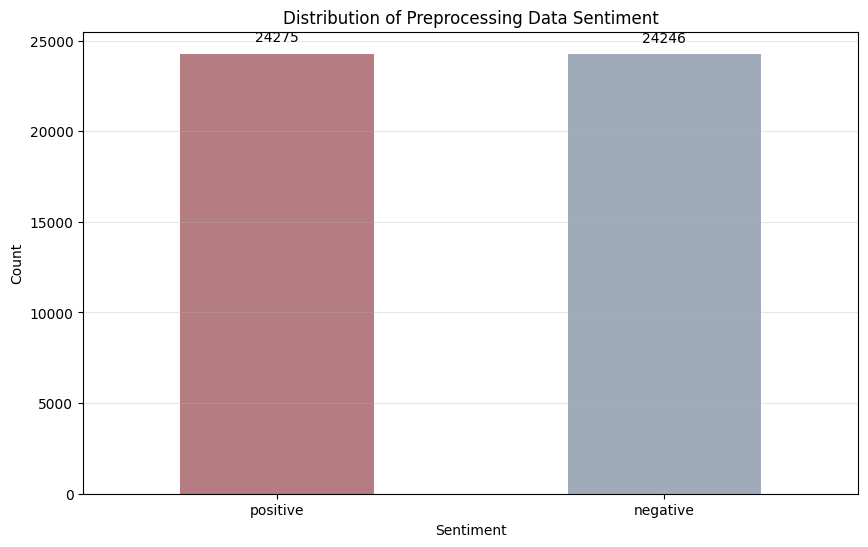

In [17]:
count_label = df['sentiment'].value_counts()

plt.figure(figsize=(10, 6))
bars = count_label.plot(kind='bar', color=['#b57c82', '#9fabb9'] )
for i, v in enumerate(count_label):
    plt.text(i, v + 500, str(v), ha='center', va='bottom')


plt.title('Distribution of Preprocessing Data Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='-', alpha=0.3)
plt.show()

### ***训练***

#### ***数据集划分***
 * 训练集70%、验证集21%、测试集9%

In [18]:
# 编码数据 negative为1,positive为0
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

# 训练集测试集划分
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(
    df['processed_text'], df['sentiment'], test_size=0.3, random_state=42, stratify=df['sentiment']
)
# Split the temp data into test and validation
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.3, random_state=42, stratify=y_temp
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 33964
Validation set size: 10189
Test set size: 4368


#### ***分词 & Transformer数据预处理***

In [19]:
#设备初始选择cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用 {device}训练")
from transformers import RobertaConfig, RobertaTokenizer, RobertaForSequenceClassification


#roberta模型初始设置
## 分词器初始化
model_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)

##定义模型设置为:二分类任务
##设置较高的DROPOUT防止过拟合
config = RobertaConfig.from_pretrained(
    model_name,
    num_labels=2,
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3,
    output_attentions=False,             # 不输出注意力权重
    output_hidden_states=False,          # 不输出所有隐藏状态
)

model = RobertaForSequenceClassification.from_pretrained(
    model_name,
    config=config
)

model.to(device)

def tokenize_data(texts, labels, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []
    
    for text in texts:
        # 使用tokenizer对文本编码
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels.values, dtype=torch.long)
    
    return input_ids, attention_masks, labels

train_inputs, train_masks, train_labels = tokenize_data(X_train, y_train, tokenizer)
val_inputs, val_masks, val_labels = tokenize_data(X_val, y_val, tokenizer)
test_inputs, test_masks, test_labels = tokenize_data(X_test, y_test, tokenizer)

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


使用 cuda训练


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### ***训练***

In [20]:
#  优化器和学习率调度器
epochs = 10
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8, weight_decay=0.01)
total_steps = len(train_dataloader) * epochs
num_warmup_steps = int(0.1 * total_steps)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, total_steps)

# 带早停机制的训练
def train_model(model, train_dataloader, val_dataloader, epochs, optimizer, scheduler, device, save_path="best_model.pt"):
    best_val_acc = 0
    training_stats = []
    best_weights = None
    early_stop_patience = 5
    epochs_no_improve = 0
    early_stopped = False

    for epoch in range(epochs):
        print(f"\n Epoch {epoch + 1} / {epochs} ===")

        model.train()
        total_train_loss = 0
        train_preds = []
        train_labels = []

        for batch in tqdm(train_dataloader):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()
            outputs = model(
                b_input_ids,
                attention_mask=b_input_mask,
                labels=b_labels
            )

            loss = outputs.loss
            logits = outputs.logits
            total_train_loss += loss.item()

            preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
            labels = b_labels.detach().cpu().numpy()
            train_preds.extend(preds)
            train_labels.extend(labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_accuracy = accuracy_score(train_labels, train_preds)

        # 验证
        model.eval()
        total_val_loss = 0
        all_preds = []
        all_labels = []

        for batch in tqdm(val_dataloader):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            with torch.no_grad():
                outputs = model(
                    b_input_ids,
                    attention_mask=b_input_mask,
                    labels=b_labels
                )

            loss = outputs.loss
            logits = outputs.logits

            total_val_loss += loss.item()
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = b_labels.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_accuracy = accuracy_score(all_labels, all_preds)

        print(f"Epoch {epoch+1:02} | Train Acc: {train_accuracy:.4f} | Train Loss: {avg_train_loss:.4f} |  Val Acc: {val_accuracy:.4f} | Val Loss: {avg_val_loss:.4f}")

        # 早停机制
        if val_accuracy > best_val_acc:
            print(f"New best val_accuracy: {val_accuracy:.4f} (improved from {best_val_acc:.4f})")
            best_val_acc = val_accuracy
            best_weights = model.state_dict()
            torch.save(best_weights, save_path)
            print(f"Best model saved to {save_path}")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"No improvement in val_accuracy. ({epochs_no_improve}/{early_stop_patience})")
            if epochs_no_improve >= early_stop_patience:
                print(f"Early stopping triggered after {early_stop_patience} epochs without improvement.")
                early_stopped = True
                break

        training_stats.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'train_accuracy': train_accuracy,
            'val_loss': avg_val_loss,
            'val_accuracy': val_accuracy
        })

    if early_stopped:
        print("Training was stopped early due to no improvement in validation loss.")

    return training_stats

training_stats = train_model(
    model,
    train_dataloader,
    val_dataloader,
    epochs=epochs,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device
)



 Epoch 1 / 10 ===


100%|██████████| 319/319 [01:10<00:00,  4.53it/s]


Epoch 01 | Train Acc: 0.7262 | Train Loss: 0.5011 |  Val Acc: 0.8721 | Val Loss: 0.3729
New best val_accuracy: 0.8721 (improved from 0.0000)
Best model saved to best_model.pt

 Epoch 2 / 10 ===


100%|██████████| 319/319 [01:10<00:00,  4.53it/s]


Epoch 02 | Train Acc: 0.8584 | Train Loss: 0.3325 |  Val Acc: 0.8991 | Val Loss: 0.2641
New best val_accuracy: 0.8991 (improved from 0.8721)
Best model saved to best_model.pt

 Epoch 3 / 10 ===


100%|██████████| 319/319 [01:10<00:00,  4.54it/s]


Epoch 03 | Train Acc: 0.8790 | Train Loss: 0.2918 |  Val Acc: 0.9045 | Val Loss: 0.2587
New best val_accuracy: 0.9045 (improved from 0.8991)
Best model saved to best_model.pt

 Epoch 4 / 10 ===


100%|██████████| 319/319 [01:10<00:00,  4.54it/s]


Epoch 04 | Train Acc: 0.8895 | Train Loss: 0.2667 |  Val Acc: 0.9095 | Val Loss: 0.2566
New best val_accuracy: 0.9095 (improved from 0.9045)
Best model saved to best_model.pt

 Epoch 5 / 10 ===


100%|██████████| 319/319 [01:10<00:00,  4.52it/s]


Epoch 05 | Train Acc: 0.8943 | Train Loss: 0.2539 |  Val Acc: 0.9103 | Val Loss: 0.2514
New best val_accuracy: 0.9103 (improved from 0.9095)
Best model saved to best_model.pt

 Epoch 6 / 10 ===


100%|██████████| 319/319 [01:10<00:00,  4.53it/s]


Epoch 06 | Train Acc: 0.9032 | Train Loss: 0.2402 |  Val Acc: 0.9103 | Val Loss: 0.2809
No improvement in val_accuracy. (1/5)

 Epoch 7 / 10 ===


100%|██████████| 319/319 [01:10<00:00,  4.53it/s]


Epoch 07 | Train Acc: 0.9097 | Train Loss: 0.2255 |  Val Acc: 0.9152 | Val Loss: 0.2656
New best val_accuracy: 0.9152 (improved from 0.9103)
Best model saved to best_model.pt

 Epoch 8 / 10 ===


100%|██████████| 319/319 [01:10<00:00,  4.53it/s]


Epoch 08 | Train Acc: 0.9146 | Train Loss: 0.2155 |  Val Acc: 0.9152 | Val Loss: 0.2711
No improvement in val_accuracy. (1/5)

 Epoch 9 / 10 ===


100%|██████████| 319/319 [01:10<00:00,  4.52it/s]


Epoch 09 | Train Acc: 0.9181 | Train Loss: 0.2082 |  Val Acc: 0.9161 | Val Loss: 0.2680
New best val_accuracy: 0.9161 (improved from 0.9152)
Best model saved to best_model.pt

 Epoch 10 / 10 ===


100%|██████████| 319/319 [01:10<00:00,  4.53it/s]


Epoch 10 | Train Acc: 0.9176 | Train Loss: 0.2097 |  Val Acc: 0.9162 | Val Loss: 0.2635
New best val_accuracy: 0.9162 (improved from 0.9161)
Best model saved to best_model.pt


### ***评估***

#### ***学习曲线***

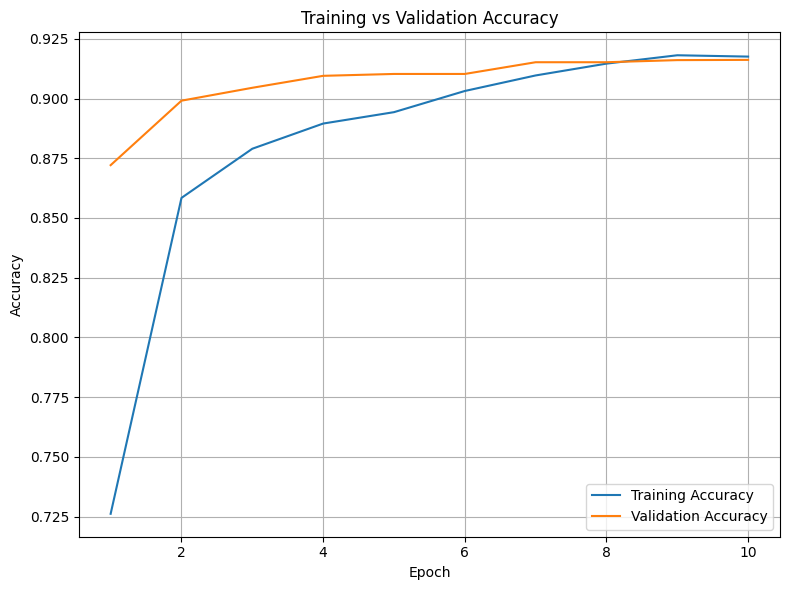

In [21]:
# 学习曲线和验证集准确率
import matplotlib.pyplot as plt

train_acc = [stat['train_accuracy'] for stat in training_stats]
val_acc = [stat['val_accuracy'] for stat in training_stats]
epochs_range = [stat['epoch'] for stat in training_stats]

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


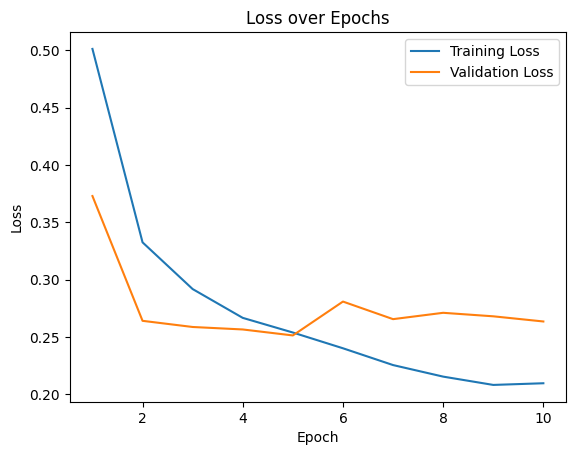

In [22]:
#训练过程中训练损失（Training Loss）和验证损失（Validation Loss）随训练轮次（Epoch）变化
import matplotlib.pyplot as plt

train_loss = [stat['train_loss'] for stat in training_stats]
val_loss = [stat['val_loss'] for stat in training_stats]
epochs_range = [stat['epoch'] for stat in training_stats]

plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()


#### ***机器学习模型评估***

In [23]:

def evaluate_test_set(model, test_dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    for batch in tqdm(test_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask
            )

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        labels = b_labels.detach().cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, digits=4)

    print("\nClassification Report:")
    print(report)

    print("Confusion Matrix:")
    print(cm)
    

    return accuracy, precision, recall, f1 ,all_labels ,all_preds


acc ,precision ,recall ,f1 ,labels ,preds=  evaluate_test_set(model, test_dataloader, device)


100%|██████████| 137/137 [00:30<00:00,  4.55it/s]


Classification Report:
              precision    recall  f1-score   support

           0     0.9202    0.9029    0.9114      2183
           1     0.9048    0.9217    0.9132      2185

    accuracy                         0.9123      4368
   macro avg     0.9125    0.9123    0.9123      4368
weighted avg     0.9125    0.9123    0.9123      4368

Confusion Matrix:
[[1971  212]
 [ 171 2014]]


#### ***混淆矩阵***

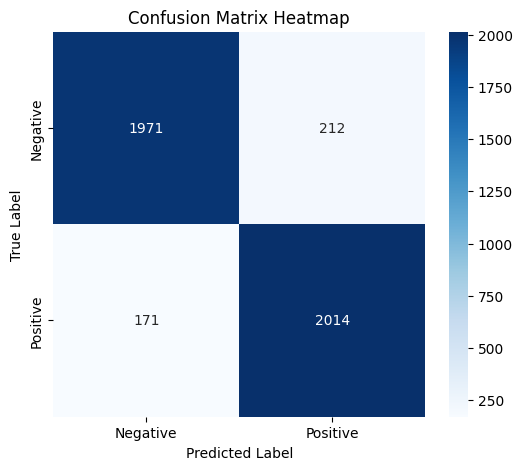

In [24]:
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative',  'Positive'],
            yticklabels=['Negative',  'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.savefig("confusion_matrix_heatmap.png")
plt.show()

#### ***文本样例***

In [25]:
def predict_sentiment(text, model, tokenizer, device):
    """预测单条文本的情感倾向（负面/正面）"""

    # 1. 文本预处理（如去除特殊字符、标准化格式等）
    processed_text = preprocess_text(text)
    
    # 2. 文本编码为模型可读的数值格式
    encoded_dict = tokenizer.encode_plus(
            text,                       # 输入文本
            add_special_tokens=True,    # 添加[CLS],[SEP]等特殊token
            max_length=max_length,      # 最大长度限制（如512）
            padding='max_length',       # 不足时填充到max_length
            truncation=True,            # 超过max_length时截断
            return_attention_mask=True, # 生成注意力掩码（标识实际内容位置）
            return_tensors='pt',        # 返回PyTorch张量格式
        )
    
    # 3. 将数据移动到指定设备（GPU/CPU）
    input_ids = encoded_dict['input_ids'].to(device)      
    attention_mask = encoded_dict['attention_mask'].to(device) 
    
    # 4. 设置模型为评估模式（关闭Dropout等训练专用层）
    model.eval()
    
    # 5. 模型预测（禁用梯度计算以提升效率）
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits  
    
    # 6. 解析预测结果
    prediction = torch.argmax(logits, dim=1).item() 
    
    # 7. 映射数字标签到情感文字
    sentiment_map = {0: 'Negative', 1: 'positive'} 
    sentiment = sentiment_map[prediction]
    
    return sentiment

# 示例用法
sample_texts = [
    "I absolutely love this product! It's amazing!",  # 正面情感示例
    "This is the worst experience I've ever had."     # 负面情感示例
]

for text in sample_texts:
    sentiment = predict_sentiment(text, model, tokenizer, device)
    print(f"文本: {text}")
    print(f"情感: {sentiment}\n")  

Text: I absolutely love this product! It's amazing!
Sentiment: positive

Text: This is the worst experience I've ever had.
Sentiment: Negative

